In [1]:
import torch
import random
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-pastel')

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
# %pylab widgetsnbextension

In [2]:
# !pip install ipywidgets
# !jupyter lab nbextension enable --py widgetsnbextension

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=False)

In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

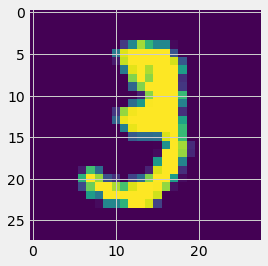

tensor(3)


In [9]:
plt.imshow(X_train[10, :, :])
plt.show()
print(y_train[10])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [11]:
class MNISTNetLight(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNetLight, self).__init__()
        
        half_hidden = int(n_hidden_neurons/2)
        q_hidden = int(half_hidden/2)
        n8_hidden = int(q_hidden/2)
        n16_hidden = int(n8_hidden/2)
        
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, half_hidden) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(half_hidden, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

In [12]:
# добавил денс слои обратной пирамидой (div 2)
# скорее для увеличения точности

class MNISTNetDeep(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNetDeep, self).__init__()
        
        half_hidden = int(n_hidden_neurons/2)
        q_hidden = int(half_hidden/2)
        n8_hidden = int(q_hidden/2)
        n16_hidden = int(n8_hidden/2)
        
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, half_hidden) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(half_hidden, q_hidden) 
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(q_hidden, n8_hidden) 
        self.ac4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(n8_hidden, n16_hidden) 
        self.ac5 = torch.nn.ReLU()
        
        self.fc6 = torch.nn.Linear(n16_hidden, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        x = self.fc5(x)
        x = self.ac5(x)
        x = self.fc6(x)
        return x


In [13]:
# изменил колв-во нейронов в первом слое
mnist_net_light = MNISTNetLight(512)
mnist_net_deep = MNISTNetDeep(512)

In [14]:
torch.cuda.is_available()

True

In [15]:
# !nvidia-smi

In [16]:
# настройка для экспериметов - частный случай
device_light = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_deep = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# для параллельной обработки на GPUS
# if torch.cuda.device_count() > 1:
#     mnist_net = nn.DataParallel(mnist_net, device_ids=[0,1,3])

mnist_net_light = mnist_net_light.to(device_light) 
mnist_net_deep = mnist_net_deep.to(device_deep)
# list(mnist_net.parameters())

In [17]:
loss_light = torch.nn.CrossEntropyLoss()
loss_deep = torch.nn.CrossEntropyLoss()

# уменьшил шаг спуска - более гладский спуск
# optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)
optimizer_light = torch.optim.RMSprop(mnist_net_light.parameters(), lr=1.0e-4)
optimizer_deep = torch.optim.RMSprop(mnist_net_deep.parameters(), lr=1.0e-4)

In [18]:
# функция обучения сети

def train_model(model, optimizer, loss, X_train, y_train, X_test, y_test, batch_size, epochs, device):
    
    EPOCHS = epochs
        
    train_accuracy_history = []
    test_accuracy_history = []

    train_loss_history = []
    test_loss_history = []
    
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(EPOCHS):
        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = model.forward(X_batch) 
            loss_value = loss(preds, y_batch)

            # добавляем метрики для train в конце каждлой эпохи
            if start_index >= len(X_train)-batch_size:
                train_loss_history.append(loss_value)
                train_accuracy = (preds.argmax(dim=1) == y_batch).float().mean()
                train_accuracy_history.append(train_accuracy)
                print(f'EPOCH: {epoch:2d}  Train accuracy = {train_accuracy}')

            loss_value.backward()
            optimizer.step()

        test_preds = model.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test))

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
        test_accuracy_history.append(accuracy)
        print(f'EPOCH: {epoch:2d}  Test accuracy  = {accuracy}')    
    
    return train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history

In [19]:
%%time
acc_train_l, acc_test_l, loss_train_l, loss_test_l = \
    train_model(mnist_net_light, 
                optimizer_light, 
                loss_light, 
                X_train, y_train, 
                X_test, y_test, 
                batch_size=30, 
                epochs=50, 
                device=device_light)

EPOCH:  0  Train accuracy = 0.9000000357627869
EPOCH:  0  Test accuracy  = 0.9645999670028687
EPOCH:  1  Train accuracy = 0.9666666984558105
EPOCH:  1  Test accuracy  = 0.9679999947547913
EPOCH:  2  Train accuracy = 1.0
EPOCH:  2  Test accuracy  = 0.9678999781608582
EPOCH:  3  Train accuracy = 1.0
EPOCH:  3  Test accuracy  = 0.9740999937057495
EPOCH:  4  Train accuracy = 1.0
EPOCH:  4  Test accuracy  = 0.9757999777793884
EPOCH:  5  Train accuracy = 0.9666666984558105
EPOCH:  5  Test accuracy  = 0.9747999906539917
EPOCH:  6  Train accuracy = 1.0
EPOCH:  6  Test accuracy  = 0.972000002861023
EPOCH:  7  Train accuracy = 1.0
EPOCH:  7  Test accuracy  = 0.9787999987602234
EPOCH:  8  Train accuracy = 1.0
EPOCH:  8  Test accuracy  = 0.9776999950408936
EPOCH:  9  Train accuracy = 1.0
EPOCH:  9  Test accuracy  = 0.9768999814987183
EPOCH: 10  Train accuracy = 1.0
EPOCH: 10  Test accuracy  = 0.9733999967575073
EPOCH: 11  Train accuracy = 1.0
EPOCH: 11  Test accuracy  = 0.9786999821662903
EPOCH: 1

In [20]:
%%time
acc_train_d, acc_test_d, loss_train_d, loss_test_d = \
    train_model(mnist_net_deep, 
                optimizer_deep, 
                loss_deep, 
                X_train, y_train, 
                X_test, y_test, 
                batch_size=30, 
                epochs=50, 
                device=device_deep)

EPOCH:  0  Train accuracy = 1.0
EPOCH:  0  Test accuracy  = 0.9634999632835388
EPOCH:  1  Train accuracy = 0.9666666984558105
EPOCH:  1  Test accuracy  = 0.9713999629020691
EPOCH:  2  Train accuracy = 1.0
EPOCH:  2  Test accuracy  = 0.9761999845504761
EPOCH:  3  Train accuracy = 0.9666666984558105
EPOCH:  3  Test accuracy  = 0.9789999723434448
EPOCH:  4  Train accuracy = 1.0
EPOCH:  4  Test accuracy  = 0.9801999926567078
EPOCH:  5  Train accuracy = 1.0
EPOCH:  5  Test accuracy  = 0.9789999723434448
EPOCH:  6  Train accuracy = 1.0
EPOCH:  6  Test accuracy  = 0.9792999625205994
EPOCH:  7  Train accuracy = 1.0
EPOCH:  7  Test accuracy  = 0.9815999865531921
EPOCH:  8  Train accuracy = 1.0
EPOCH:  8  Test accuracy  = 0.9803999662399292
EPOCH:  9  Train accuracy = 1.0
EPOCH:  9  Test accuracy  = 0.9817999601364136
EPOCH: 10  Train accuracy = 1.0
EPOCH: 10  Test accuracy  = 0.9794999957084656
EPOCH: 11  Train accuracy = 1.0
EPOCH: 11  Test accuracy  = 0.9815999865531921
EPOCH: 12  Train accur

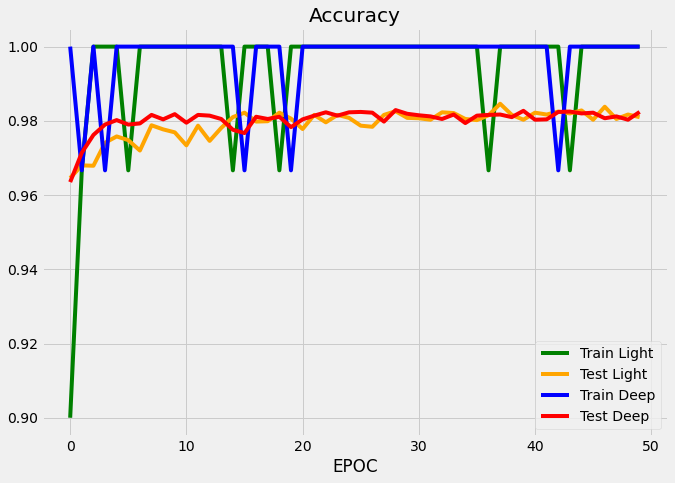

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title('Accuracy')
ax.set_xlabel('EPOC')
ax.plot(acc_train_l, 'g', label='Train Light' )
ax.plot(acc_test_l, 'orange', label='Test Light' )
ax.plot(acc_train_d, 'b', label='Train Deep' )
ax.plot(acc_test_d, 'r', label='Test Deep' )

ax.legend()

plt.show()


In [22]:
idx_acc_max = np.argmax(acc_test_l)
print(f'[Light Max test] Accuracy = {acc_test_l[idx_acc_max]}, index = {idx_acc_max}, Loss = {loss_test_l[idx_acc_max]}')
idx_acc_max = np.argmax(acc_test_d)
print(f'[Deep Max test]  Accuracy = {acc_test_d[idx_acc_max]}, index = {idx_acc_max}, Loss = {loss_test_d[idx_acc_max]}')

[Light Max test] Accuracy = 0.9845999479293823, index = 37, Loss = 0.20819313824176788
[Deep Max test]  Accuracy = 0.9828999638557434, index = 28, Loss = 0.13925716280937195


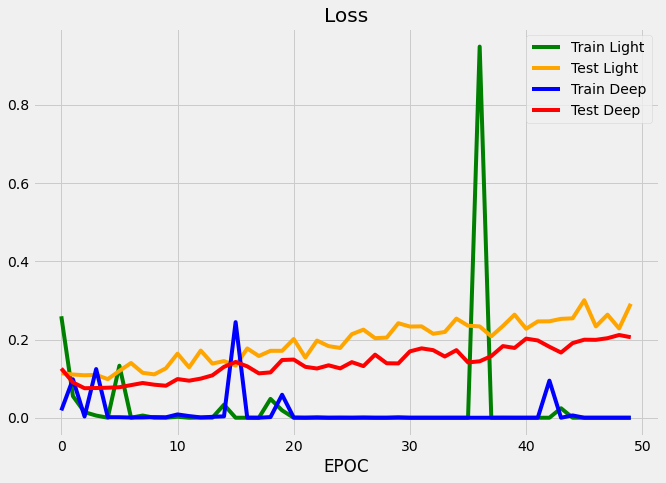

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title('Loss')
ax.set_xlabel('EPOC')
ax.plot(loss_train_l, 'g', label='Train Light' )
ax.plot(loss_test_l, 'orange', label='Test Light' )
ax.plot(loss_train_d, 'b', label='Train Deep' )
ax.plot(loss_test_d, 'r', label='Test Deep' )
ax.legend()

plt.show()


In [24]:
idx_loss_min = np.argmin(loss_test_l)
print(f'[Light Min test] Loss = {loss_test_l[idx_loss_min]}, index = {idx_loss_min}, Accuracy = {loss_test_l[idx_loss_min]}')
idx_loss_min = np.argmin(loss_test_d)
print(f'[Deep Min test]  Loss = {loss_test_d[idx_loss_min]}, index = {idx_loss_min}, Accuracy = {loss_test_d[idx_loss_min]}')

[Light Min test] Loss = 0.09867030382156372, index = 4, Accuracy = 0.09867030382156372
[Deep Min test]  Loss = 0.07549087703227997, index = 2, Accuracy = 0.07549087703227997


<b>Наблюдение:</b>
<p>
Следующие параметры привели к переобучению
<ol>
    <li> Смена активации слоев на RELU </li>
    <li> Смена оптимизатора на RMSprop и выставление ему шага 1.0e-4 </li>
    <li> Увеличиние кол-ва эпох и уменьшение батча также ведет к переобучению </li>
    <li> Увеличиние кол-ва слоев увеличило точность модели </li>
    <li> Более глубокая сеть переобучается медленне если смотреть на loss </li>
</ol>
